Lección 4. ACF, PACF y densidad espectral de modelos MA
=======================================================

**Author:** Marcos Bujosa



<div class="abstract" id="org4ffaeb8">
<p>
Veremos tres funciones que describen las características correspondientes a los momentos de segundo orden de los procesos lineales: la función de autocorrelación (ACF), la función de autocorrelación parcial (PACF) y la densidad espectral (estas tres funciones son transformaciones de la función de autocovarianzas del proceso). Veremos la estructura de estas funciones en procesos lineales genéricos y hoy lo particularizaremos a procesos de ruido blanco y procesos MA($q$).
</p>

</div>

-   ([slides](https://mbujosab.github.io/Econometria-Aplicada/Transparencias/Lecc04.slides.html)) &mdash; ([html](https://mbujosab.github.io/Econometria-Aplicada/Lecciones-html/Lecc04.html)) &mdash; ([pdf](https://mbujosab.github.io/Econometria-Aplicada/Lecciones-pdf/Lecc04.pdf)) &mdash; ([mybinder](https://mybinder.org/v2/gh/mbujosab/Econometria-Aplicada/gh-pages?labpath=CuadernosElectronicos/Lecc04.ipynb))

<style>
.reveal  td {font-size: 60%;}
</style>



#### Carga de algunos módulos de python y creación de directorios auxiliares



In [1]:
# Para trabajar con los datos y dibujarlos necesitamos cargar algunos módulos de python
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib as mpl
# definimos parámetros para mejorar los gráficos
mpl.rc('text', usetex=False)
import matplotlib.pyplot as plt   # data visualization

##### Directorio auxiliar para albergar las figuras de la lección:



para publicar la lección como pdf o página web, necesito los gráficos como ficheros `.png` alojados algún directorio específico:



In [2]:
imagenes_leccion = "./img/lecc04" # directorio para las imágenes de la lección
import os
os.makedirs(imagenes_leccion, exist_ok=True) # crea el directorio si no existe

#### Gráficos para las ACF, PACF y densidades espectrales teóricas



In [3]:
# Módulos necesarios
import statsmodels.api as sm
from statsmodels.tsa.arima_process import ArmaProcess
from scipy import signal
from scipy.signal import freqz
from numpy.polynomial import Polynomial
import math

La siguiente función que calcula la PACF a partir de la ACF resolviendo las [ecuaciones de Yule-Walker](./Lecc05.html#org392fab2) recursivamente con el algoritmo [Levinson-Durbin](https://en.wikipedia.org/wiki/Levinson_recursion); véase *Pourahmadi, M. (2001, Capítulo 7)* o *Brockwell & Davis (1991, Capitulo 5)*).



In [4]:
def theoretical_pacf_from_acf(acf_vals):
    """
    Calcula la PACF teórica (para lags >= 0) de forma paramétrica usando el algoritmo de Durbin-Levinson.
    Se asume que acf_vals es un array tal que acf_vals[0] corresponde a lag 0.
    
    Retorna un array donde el coeficiente en la posición k corresponde a la PACF en el lag k.
    """
    nlags = len(acf_vals)-1
    # Matriz para almacenar los coeficientes (phi)
    phi = np.zeros((nlags+1, nlags+1))
    # v guarda la varianza de error en cada paso
    v = np.zeros(nlags+1)
    pacf = np.zeros(nlags+1)
    v[0] = acf_vals[0]
    pacf[0] = 1.0  # Por convención, PACF(0)=1.
    
    for k in range(1, nlags+1):
        if k == 1:
            phi[1,1] = acf_vals[1] / acf_vals[0]
            pacf[1] = phi[1,1]
            v[1] = v[0]*(1 - phi[1,1]**2)
        else:
            sum_val = 0.0
            # Sumar phi[k-1,j]*acf_vals[k-j] para j=1,...,k-1.
            for j in range(1, k):
                sum_val += phi[k-1, j] * acf_vals[k - j]
            phi[k, k] = (acf_vals[k] - sum_val) / v[k-1]
            pacf[k] = phi[k, k]
            for j in range(1, k):
                phi[k, j] = phi[k-1, j] - phi[k, k] * phi[k-1, k - j]
            v[k] = v[k-1] * (1 - phi[k, k]**2)
    return pacf  # Incluye PACF en lag 0 con valor 1.

La siguiente función pinta las ACF, PACF y densidad espectral teóricas.



In [5]:
def plot_arma_parametric_diagnostics(ar_params=[1,], ma_params=[1,], sigma2=1, lags=20):
    """
    Genera y retorna una figura con tres subgráficas para un modelo ARMA:
      - ACF teórica (omitiendo retardo 0)
      - PACF teórica paramétrica (calculada vía el algoritmo de Durbin-Levinson, omitiendo retardo 0)
      - Densidad espectral teórica
    
    Parámetros:
      ar_params : array-like
          Coeficientes del polinomio AR (incluye el 1 inicial).
      ma_params : array-like
          Coeficientes del polinomio MA (incluye el 1 inicial).
      sigma2 : float
          Varianza del ruido Uₜ.
      lags : int, opcional
          Número de retardos considerados (por defecto 20).
    
    Retorna:
      fig : objeto matplotlib.figure.Figure
    """
    phi   = Polynomial(ar_params, symbol='B')
    theta = Polynomial(ma_params, symbol='B')
    # Crear el proceso ARMA
    arma_process = ArmaProcess(ar=phi.coef, ma=theta.coef)
    
    # 1. Calcular la ACF teórica
    acf_theo = arma_process.acf(lags=lags)
    lags_theo = np.arange(len(acf_theo))
    # Omitir el retardo 0 para gráficos de ACF y PACF:
    acf_plot = acf_theo[1:]
    lags_plot = lags_theo[1:]
    
    # 2. Calcular la PACF teórica de forma paramétrica a partir de la ACF
    pacf_theo = theoretical_pacf_from_acf(acf_theo)
    pacf_plot = pacf_theo[1:]
    lags_pacf = np.arange(len(pacf_theo))[1:]
    
    # 3. Calcular la densidad espectral teórica usando freqz
    w, h = freqz(theta.coef, phi.coef, worN=1024)
    freq = w / (2 * np.pi)  # Conversión de radianes/muestra a ciclos/muestra
    spectrum = (sigma2 / (2 * np.pi)) * np.abs(h)**2
    
    # 4. Graficar los tres subgráficos
    fig, axs = plt.subplots(1, 3, figsize=(18, 3))
    
    # ACF teórica
    axs[0].stem(lags_plot, acf_plot, basefmt=" ")
    axs[0].axhline(0, color='black', lw=0.5, linestyle='--')
    axs[0].set_xlabel('Retardo')
    axs[0].set_ylabel('ACF')
    
    # PACF teórica paramétrica
    axs[1].stem(lags_pacf, pacf_plot, basefmt=" ")
    axs[1].axhline(0, color='black', lw=0.5, linestyle='--')
    axs[1].set_xlabel('Retardo')
    axs[1].set_ylabel('PACF')
    
    # Densidad espectral teórica
    axs[2].plot(freq, spectrum)
    axs[2].axhline(0, color='black', lw=0.5, linestyle='--')
    axs[2].set_xlabel('Frecuencia')
    axs[2].set_ylabel('Densidad Espectral')
    
    plt.tight_layout()
    plt.close(fig)
    return fig

Breve explicación de la anterior función `plot_arma_parametric_diagnostics`:

1.  La función recibe los parámetros del modelo ARMA y el número de retardos.
2.  Se calcula la ACF teórica y a partir de ella la PACF con `theoretical_pacf_from_acf`; en la gráfica se omite el retardo cero.
3.  La densidad espectral teórica $ S(\omega) $ se obtiene mediante la función freqz y la fórmula $$S(\omega)=\frac{\sigma^2}{2\pi}\Biggl|\frac{\sum_{j=0}^{q}\theta_j e^{-i2\pi \omega\,j}}{\sum_{k=0}^{p}\phi_k e^{-i2\pi \omega\,k}}\Biggr|^2.$$
    Donde:
    
    -   $\sigma^2$ es la varianza del término de error (innovación) del modelo.
    -   $(\theta_j \mid j=0:q)$ son los coeficientes del polinomio de medias móviles (MA), de modo que el polinomio MA es: 
        $\theta(z) = \sum_{j=0}^{q}\theta_j\,z^j$.
    
    -   $(\phi_k \mid k=0:p)$ son los coeficientes del polinomio autorregresivo (AR), de modo que el polinomio AR es:
        $\phi(z) = \sum_{k=0}^{p}\phi_k\,z^k$.
    
    -   Al evaluar estos polinomios en $z = e^{-i\,2\pi \omega}$ se obtiene la respuesta en frecuencia del modelo:
        $$H(e^{-i\,2\pi \omega})=\frac{\theta\bigl(e^{-i\,2\pi \omega}\bigr)}{\phi\bigl(e^{-i\,2\pi \omega}\bigr)}.$$
    
    -   El módulo al cuadrado de $ H(e^{-i\,2\pi \omega}) $ multiplicado por $\frac{\sigma^2}{2\pi}$ es la densidad espectral.
    
    Esta fórmula es fundamental porque permite conocer la distribución de la varianza del proceso a lo largo de las diferentes frecuencias, lo cual es clave para analizar las propiedades dinámicas en modelos ARMA.

4.  Se crean tres subgráficos, y se añade una línea horizontal en y=0 en cada uno (`axhline`).
5.  Por último, la función retorna el objeto figura.



Función que simula un modelo ARIMA y pinta la serie temporalm, las ACF, PACF y densidad espectral estimadas con los datos simulados.



In [6]:
def plot_arma_analysis(ar_params=[1,], ma_params=[1,], sigma2=1, lags=20, n=400, seed=0):

    lags=math.floor(n/2) if n/2 < lags else lags
    
    phi   = Polynomial(ar_params, symbol='B')
    theta = Polynomial(ma_params, symbol='B')
    arma_process = sm.tsa.ArmaProcess(phi.coef, theta.coef)
    
    # Simulación de la serie temporal
    if seed:
        np.random.seed(seed)
    data = arma_process.generate_sample(nsample=n)
       
    # Crear la figura
    fig = plt.figure(figsize=(18, 7))
    
    # Subgráfico de la serie temporal
    ax1 = fig.add_subplot(2, 1, 1)
    ax1.plot(data, color='blue')
    ax1.set_xlabel('t')
    
    # Crear una fila de 3 subgráficos para ACF, PACF y periodograma
    ax2 = fig.add_subplot(2, 3, 4)  # Fila 2, Columna 1
    sm.graphics.tsa.plot_acf(data, lags=lags, ax=ax2, title='ACF Estimada', zero=False, auto_ylims=True)
    ax2.set_xlabel('Retardo')

    ax3 = fig.add_subplot(2, 3, 5)  # Fila 2, Columna 2
    sm.graphics.tsa.plot_pacf(data, lags=lags, ax=ax3, title='PACF Estimada', zero=False, auto_ylims=True)
    ax3.set_xlabel('Retardo')
    
    ax4 = fig.add_subplot(2, 3, 6)  # Fila 2, Columna 3
    f, Pxx = signal.welch(data, fs=1, nperseg=256)
    ax4.plot(f, Pxx, color='purple')
    ax4.set_title('Periodograma Estimado')
    ax4.set_xlabel('Frecuencia')
    #ax4.set_ylabel('Densidad Espectral')
    ax4.set_xlim(0, 0.5)  # Limitar el eje x a 0.5

    plt.tight_layout()
    plt.close(fig)    
    return fig

Función que muestra las raíces de un polinomio en una tabla



In [7]:
def polynomial_roots_table(coef_polinomio):

    polinomio = Polynomial(coef_polinomio, symbol='B')
    roots = polinomio.roots()
    
    # Contar la multiplicidad de las raíces
    unique_roots, counts = np.unique(roots, return_counts=True)

    # Crear listas para cada columna de la tabla
    real_parts = []
    imaginary_parts = []
    moduli = []
    frequencies = []
    periods = []
    multipliers = []

    for root, count in zip(unique_roots, counts):
        real = root.real
        imag = root.imag
        
        # Calcular módulo
        modulus = np.abs(root)
        moduli.append(modulus)

        # Calcular frecuencia y período
        frequency = np.abs(np.angle(root)) / (2*np.pi)
        period = 1/frequency if frequency else 'Inf'
        
        # Append results
        real_parts.append(real)
        imaginary_parts.append(imag)
        frequencies.append(frequency)
        periods.append(period)
        multipliers.append(count)  # Multiplicidad

    # Crear un DataFrame para mostrar la tabla
    table = pd.DataFrame({
        'P. real': real_parts,
        'P. imag.': imaginary_parts,
        'Módulo': moduli,
        'Frecuencia': frequencies,
        'Periodo': periods,
        'Multip.': multipliers
    })
    
    # Ordenar la tabla por la columna 'Frequency' en orden ascendente
    table = table.sort_values(by='Frecuencia').round(6)
    table2 = [list(table)] + [None] + table.values.tolist()
    
    return table2

## Funciones de autocovarianzas y de autocorrelación (ACF)



Si un proceso estocástico es estacionario, la covarianza entre $X_t$ y $X_{t+k}$ no depende de $t$; tan solo depende de la distancia temporal $k$ entre ambas variables aleatorias: $\;Cov(X_t,X_{t-k})=\gamma_k.\;$ 

-   La secuencia $\boldsymbol{\gamma}=(\gamma_k\mid k\in\mathbb{Z})$ se denomina *función de
    autocovarianzas*
-   Dividiendo $\boldsymbol{\gamma}$ por $\gamma_0$ obtenemos la
    secuencia $\boldsymbol{\rho}=(\rho_k\mid k\in\mathbb{Z})$ donde
    $$\rho_k=\frac{Cov(X_t,X_{t-k})}{\sqrt{Var(X_t)Var(X_{t-k})}}=\frac{\gamma_k}{\gamma_0},$$
    
    que se denomina *función de autocorrelación* (ACF).



Veamos otras transformaciones de $\boldsymbol{\gamma}$ que subrayan
diferentes características de la interdependencia temporal en un
proceso estocástico.



## Función de autocorrelación parcial  (PACF)



La *correlación parcial* entre dos variables $X_t$ y $X_{t-k}$ de un
proceso estacionario $\boldsymbol{X}$ mide su correlación una vez
descontado el efecto de las variables $X_{t-1},\ldots X_{t-(k-1)}$ que
median entre ambas.
$$X_t,\ \overbrace{X_{t-1},\ldots X_{t-(k-1)},}\ X_{t-k}$$

Si denotamos con $\widehat{X_t}$ y $\widetilde{X_{t-k}}$ los ajustes de
las respectivas regresiones de $X_t$ y $X_{t-k}$ sobre $X_{t-1},\ldots
X_{t-(k-1)};\;$ la *correlación parcial* $\pi_k$ entre $X_t$ y $X_{t+k}$ es la
correlación entre los residuos de sendas regresiones:
$$\pi_k=Corr\Big((X_t-\widehat{X_t}),\ (X_{t-k}-\widetilde{X_{t-k}})\Big)$$



En un proceso débilmente estacionario las correlaciones parciales solo
dependen de la distancia $k$, lo que permite definir la siguiente
secuencia.

**La función de autocorrelación parcial** (PACF) de un proceso
estocástico estacionario $\boldsymbol{X}$ es la siguiente secuencia
$\boldsymbol{\pi}$ simétrica ($\pi_{-k}=\pi_k$):

$$\boldsymbol{\pi}=(\pi_k\mid k\in\mathbb{Z})=
\begin{cases} 
  \pi_0 & = \rho_0 ={\color{blue}{1}}\\\\ 
  \pi_1 &=Corr(X_t,\ X_{t-1})=\rho_1=\frac{\gamma_1}{\gamma_0}\\\\ 
  \pi_k &=Corr\Big((X_t-\widehat{X_t}),\ (X_{t-k}-\widetilde{X_{t-k}})\Big)
\end{cases},$$ 
donde $\widehat{X_t}$ y $\widetilde{X_{t-k}}$ son los ajustes de las
respectivas regresiones de $X_t$ y $X_{t-k}$ sobre $X_{t-1},\ldots
X_{t-(k-1)};\;$ i.e., las proyecciones ortogonales sobre
$\bar{sp}(1,X_{t-1},\ldots X_{t-(k-1)})$.



La magnitud de la correlación parcial $\;\pi_k\;$ **refleja la mejora
en la predicción de $\widehat{X_t}$ si** en lugar de usar una
combinación lineal con solo los $k-1$ primeros retardos,
$\widehat{X_t}=\widehat{\alpha_0}+\sum_{j=1}^{k-1}\widehat{\alpha_j}
X_{t-j}$, **empleamos $k$ retardos** (i.e., un retardo más).

Así, la PACF nos ayudará a identificar el orden de procesos autoregresivos.



Hay una correspondencia uno-a-uno entre la función de autocovarianzas
$\boldsymbol{\gamma}$ y la PACF $\boldsymbol{\pi}$. 

Es decir, es posible reconstruir una de las secuencias a partir de la
otra (por ejemplo resolviendo las [ecuaciones de Yule-Walker](./Lecc05.html#org392fab2)
recursivamente con el algoritmo [Levinson-Durbin](https://en.wikipedia.org/wiki/Levinson_recursion); véase
*Pourahmadi, M. (2001, Capítulo 7)* o *Brockwell & Davis (1991,
Capitulo 5)*)



Así, la PACF $\boldsymbol{\pi}$ puede verse como una reparametrización de la función de autocovarianzas $\boldsymbol{\gamma}$.

Veamos otra transformación de $\boldsymbol{\gamma}$ que también
arrojará luz sobre las propiedades de un proceso estocástico.



## Densidad espectral



Si $\boldsymbol{X}$ es un proceso estocástico con función de
autocovarianzas $\boldsymbol{\gamma}\in\ell^1$, es decir, con función
de autocovarianzas absolutamente sumable,
$$\sum_{k\in\mathbb{Z}}|\gamma_k|<\infty,$$ entonces definimos la
*densidad espectral* de $\boldsymbol{X}$ como $$f(\omega)
\quad=\quad\frac{1}{2\pi}\sum_{k\in\mathbb{Z}}\gamma_k e^{-i k\omega}
\quad=\quad{\color{blue}{\frac{1}{2\pi}\sum_{k\geq0}\gamma_k \cos(k\omega)}},\qquad
\omega\in[-\pi,\pi],$$
(donde $w$ son las frecuencias de oscilación de la serie).



La *densidad espectral* $f(\omega)$ satisface las siguientes
propiedades:

1.  $f(\omega)=f(-\omega)$
2.  $f(\omega)\geq0$
3.  $\int_{-\pi}^\pi f(\omega)d\omega<\infty$



Es más, partiendo de la densidad espectral se pueden calcular las
covarianzas $$\gamma_k=\int_{-\pi}^\pi f(\omega)e^{-i
k\omega}d\omega;\quad k\in\mathbb{Z}$$



Consecuentemente, para $k=0$
$$\sigma^2=\gamma_0=\int_{-\pi}^\pi f(\omega)d\omega.$$

Por tanto podemos interpretar la densidad espectral como una
descomposición de la varianza en sumas de oscilaciones con distintas frecuencias (o periodos).



($Periodo=\frac{1}{Frecuencia}$, donde la Frecuencia = Nº de ciclos por unidad de tiempo).



La ACF, la PACF y la *densidad espectral* son funciones que dependen
únicamente de los dos primeros momentos de la distribución.

Su estimación y posterior análisis son la herramienta fundamental para
elegir un modelo ARMA para una serie temporal *\`\`estacionaria''*.

Para entenderlo debemos ver cómo son estas funciones en algunos
modelos lineales concretos.



## ACF, PACF y densidad espectral de algunos modelos lineales



### Procesos lineales causales



Sea $\;\boldsymbol{X}=\boldsymbol{\psi}*\boldsymbol{U},\;$
donde $\;\boldsymbol{U}\sim WN(0,\sigma^2)\;$ y
$\;\boldsymbol{\psi}\in\ell^2\;$ es una serie formal:
$$X_t=\sum_{j\geq0}\psi_j U_{t-j}.$$ Por la [lección anterior](./Lecc03.html#org6668e5d) sabemos
que $\;E(X_t)=0\;$ y que

-   $\boldsymbol{\gamma} \;=\; \sigma^2 \boldsymbol{\psi}(z)*\boldsymbol{\psi}(z^{-1})$



Es decir, 
$$\gamma_k = \sigma^2\sum_{j=0}^\infty \psi_{j+|k|}\cdot\psi_j.$$ 
Por otra parte, $\;\gamma_k\to0\;$ cuando $\;k\to\infty$



A partir de $\boldsymbol{\gamma}$ obtenemos las otras tres funciones:

**ACF**: $\;\boldsymbol{\rho} \;=\; \frac{1}{\gamma_0}\boldsymbol{\gamma}$

**Dens. espectral**:  $\;f(\omega)=\frac{1}{2\pi}\sum_{k\geq0}\gamma_k\cos(k\omega)$

**PACF**: $\;\boldsymbol{\pi}\in\ell^2,\quad$ i.e., $\;\pi_k\to0\;$ cuando $\;k\to\infty$ 



### Proceso de Ruido Blanco



Sea $\boldsymbol{X}=1*\boldsymbol{U}$,
donde $\;\boldsymbol{U}\sim WN(0,\sigma^2)\;;$ es decir $X_t=U_t$ para
$t\in\mathbb{Z}$. Entonces

-   $\boldsymbol{\gamma} \;=\; \sigma^2 (1z^0*1z^{0}) \;=\; \sigma^2z^0 \;=\; (\ldots,0,0,{\color{blue}{\sigma^2}},0,0,\ldots)$

-   $\boldsymbol{\rho} \;=\; \frac{1}{\gamma_0}\boldsymbol{\gamma} \;=\;
      \frac{1}{\sigma^2}\boldsymbol{\gamma} \;=\; 1 z^0 \;=\;
      (\ldots,0,0,{\color{blue}{1}},0,0,\ldots)$

-   $f(\omega) \;=\; \frac{1}{2\pi}\sum_{k\geq0}\gamma_k \cos(k\omega) \;=\; \frac{\sigma^2}{2\pi} \cos(0\omega) \;=\; \frac{\sigma^2}{2\pi};\quad \omega\in[-\pi,\pi]$

-   $\boldsymbol{\pi} \;=\; 1 z^0 \;=\; (\ldots,0,0,{\color{blue}{1}},0,0,\ldots)$



In [8]:
ar_params = [1,]
ma_params = [1,]
fig = plot_arma_parametric_diagnostics(ar_params, ma_params, 1, lags=20)
fig.savefig('./img/lecc04/ACFwhitenoise.png', dpi=300, bbox_inches='tight')

![img](./img/lecc04/ACFwhitenoise.png)



In [9]:
fig = plot_arma_analysis(ar_params, ma_params, seed=2026)
fig.savefig('./img/lecc04/SimulWhitenoise.png', dpi=300, bbox_inches='tight')

![img](./img/lecc04/SimulWhitenoise.png)



### Proceso de media móvil MA($q$)



Sea $\boldsymbol{X}=\boldsymbol{\theta}*\boldsymbol{U}$, con $\;\boldsymbol{U}\sim WN(0,\sigma^2)\;$ y donde $\boldsymbol{\theta}$ es un polinomio de orden $q>0$, con $\theta_0=1$ y con todas sus raíces fuera del círculo unidad $(\boldsymbol{\theta}^{-\triangleright}\in\ell^1)$, es decir $$X_t=\sum_{j=1}^q\theta_j U_{t-j}+U_t.$$

Entonces $\;E(X_t)=0\;$ y

$\boldsymbol{\gamma}=\; \sigma^2 \boldsymbol{\theta}(z)*\boldsymbol{\theta}(z^{-1}) \;=\; \sigma^2 \sum\limits_{j=0}^q \theta_{j+k}\theta_{j} z^{k}$ (grado $q$; cogrado $-q$) ([Lecc. 02](https://mbujosab.github.io/Econometria-Aplicada/Lecciones-pdf/Lecc02.pdf#subsection.9.3))

$\boldsymbol{\rho}=\; \frac{1}{\gamma_0}\boldsymbol{\gamma}$

$f(\omega)=\; \frac{\sigma^2}{2\pi}\boldsymbol{\theta}(e^{-i\omega})\cdot\boldsymbol{\theta}(e^{i\omega}) \;=\; \frac{1}{2\pi}\sum\limits_{h=0}^q \gamma_h \cos(h\omega);\quad \omega\in[-\pi,\pi]$ ($q$ cosenos $+1$)

$\boldsymbol{\pi}\;$ con grado $\infty$ y cogrado $-\infty$. Su magnitud decae paulatinamente cuando $\;k\to\infty$



Un proceso MA es <u>siempre estacionario.</u>

**Tipos de representación del proceso**

-   **Como suma ponderada finita:** (número finito de parámetros)
    $$\boldsymbol{X}=\boldsymbol{\theta}*\boldsymbol{U}
      \quad\Rightarrow\quad X_t=\boldsymbol{\theta}(\mathsf{B})U_t$$
-   **Como suma ponderada infinita:** (<u>solo existe si es invertible</u>):
    $$\frac{1}{\boldsymbol{\theta}}*\boldsymbol{X}=\boldsymbol{U}
      \quad\Rightarrow\quad
      \frac{1}{\boldsymbol{\theta}}(\mathsf{B})X_t=U_t$$

Para ser invertible raíces $\boldsymbol{\theta}$ fuera del círculo
unidad
$(\boldsymbol{\theta}^{-\triangleright}=\boldsymbol{\theta}^{-1}\in\ell^1)$



### Proceso de media móvil MA($1$)



Sea $\boldsymbol{X}=(1-\theta z)*\boldsymbol{U}$ con $|\theta|<1$ y
con $\;\boldsymbol{U}\sim WN(0,\sigma^2)\;$, es decir $$X_t=U_t-\theta
U_{t-1}.$$

-   $\boldsymbol{\gamma} \;=\; \sigma^2 (1-\theta z)*(1-\theta z^{-1})
      \;=\; \sigma^2 (\ldots,\ 0\ ,\ -\theta,\
      {\color{blue}{(1+\theta^2)}},\ -\theta,\ 0,\ \ldots)$

-   $\boldsymbol{\rho} \;=\; \frac{1}{\gamma_0}\boldsymbol{\gamma} \;=\;
      \frac{1}{\sigma^2(1+\theta^2)}\boldsymbol{\gamma}\;=\; (\ldots,\ 0\
      ,\ \frac{-\theta}{1+\theta^2},\ {\color{blue}{1}},\
      \frac{-\theta}{1+\theta^2},\ 0,\ \ldots)$

-   $f(\omega) \;=\;
      \frac{\sigma^2}{2\pi}\boldsymbol{\theta}(e^{-i\omega})\cdot\boldsymbol{\theta}(e^{i\omega})
      \;=\;
      \frac{\sigma^2}{2\pi}\Big((1+\theta^2)\;-\;2\theta\cos(\omega)\Big);\quad
      \omega\in[-\pi,\pi]$

-   $\boldsymbol{\pi} \;=\; \sum\limits_{k\in\mathbb{Z}}{  \frac{-\theta^k(1-\theta^2)}{1-\theta^{2(k+1)}} z^k}$



#### MA(1) con raíz positiva



$$\boldsymbol{\theta}(z)=1-0.9z\quad\Rightarrow\quad X_t=
(1-0.9 \mathsf{B})U_t\qquad {\color{blue}{(\theta>0)}}$$


| P. real|P. imag.|Módulo|Frecuencia|Periodo|Multip.|
|---|---|---|---|---|---|
| 1.111111|0.0|1.111111|0.0|Inf|1|



In [10]:
ar_params = [1,]
ma_params = [1, -0.9]
fig = plot_arma_parametric_diagnostics(ar_params, ma_params, sigma2=1, lags=20)
fig.savefig('./img/lecc04/ACF-MA1p.png', dpi=300, bbox_inches='tight')

![img](./img/lecc04/ACF-MA1p.png)



In [11]:
# Ejemplo de uso
fig = plot_arma_analysis(ar_params, ma_params)
fig.savefig('./img/lecc04/Sim-MA1p.png', dpi=300, bbox_inches='tight')

![img](./img/lecc04/Sim-MA1p.png)



#### MA(1) con raíz negativa



$$\boldsymbol{\theta}(z)=1+0.9z\quad\Rightarrow\quad X_t=
(1+0.9 \mathsf{B})U_t\qquad {\color{blue}{(\theta<0)}}$$


| P. real|P. imag.|Módulo|Frecuencia|Periodo|Multip.|
|---|---|---|---|---|---|
| -1.111111|0.0|1.111111|0.5|2.0|1.0|



In [12]:
ar_params = [1,]
ma_params = [1, 0.9]
fig = plot_arma_parametric_diagnostics(ar_params, ma_params, sigma2=1, lags=20)
fig.savefig('./img/lecc04/ACF-MA1n.png', dpi=300, bbox_inches='tight')

![img](./img/lecc04/ACF-MA1n.png)



In [13]:
fig = plot_arma_analysis(ar_params, ma_params)
fig.savefig('./img/lecc04/Sim-MA1n.png', dpi=300, bbox_inches='tight')

![img](./img/lecc04/Sim-MA1n.png)



### Proceso de media móvil MA($2$)



Sea $\boldsymbol{X}=(1-\theta_1 z-\theta_2 z^2)*\boldsymbol{U}$, con
$\;\boldsymbol{U}\sim WN(0,\sigma^2)\;$ y con
$$\theta_1+\theta_2<1;\qquad \theta_2-\theta_1<1;\qquad |\theta_2|<1;\quad \text{(i.e., invertible)}$$
es decir $X_t=U_t-\theta_1 U_{t-1}-\theta_2 U_{t-2}$.

-   $\boldsymbol{\gamma} \;=\; \sigma^2 (1-\theta_1 z-\theta_2 z^2)*(1-\theta_1 z^{-1}-\theta_2 z^{-2})$
    
    $\gamma_0={\color{blue}{\sigma^2(1+\theta_1^2+\theta_2^2)}};\qquad$
    $\gamma_1=\sigma^2\big(-\theta_1(1-\theta_2)\big);\qquad$
    $\gamma_2=\sigma^2(-\theta_2)$
    
    $\gamma_3=\gamma_4=\cdots=0\qquad$ (y es simétrica)

-   $\boldsymbol{\rho} \;=\; \frac{1}{\gamma_0}\boldsymbol{\gamma} \;=\; \frac{1}{\sigma^2(1+\theta_1^2+\theta_2^2)}\boldsymbol{\gamma}$

-   $f(\omega) \;=\;  \frac{\sigma^2}{2\pi}\Big((1+\theta_1^2+\theta_2^2)\;-\;2\theta_1(1+\theta_2)\cos(\omega)\;-\;2\theta_2\cos(2\omega)\Big)$

-   $\boldsymbol{\pi}$ tiene una expresión complicada, pero su magnitud
    decae paulatinamente.



![img](./img/lecc04/MA2roots.png "El interior del triángulo es la región paramétrica donde un MA(2) es invertible.")



#### MA(2) con dos parámetros positivos ($+$, $+$)



$$
\boldsymbol{\theta}(z) = 1-0.6z -0.3z^2
\quad\Rightarrow\quad 
X_t=(1-0.6\mathsf{B}-0.3\mathsf{B}^2)U_t
;\;\; 
{\color{blue}{(\theta_1>0 \;\text{y}\; \theta_2>0)}}
$$


| P. real|P. imag.|Módulo|Frecuencia|Periodo|Multip.|
|---|---|---|---|---|---|
| 1.081666|0.0|1.081666|0.0|Inf|1|
| -3.081666|0.0|3.081666|0.5|2.0|1|



In [14]:
ar_params = [1,]
ma_params = [1, -0.6, -0.3]
fig = plot_arma_parametric_diagnostics(ar_params, ma_params, sigma2=1, lags=20)
fig.savefig('./img/lecc04/ACF-MA2thpp.png', dpi=300, bbox_inches='tight')

![img](./img/lecc04/ACF-MA2thpp.png)



In [15]:
fig = plot_arma_analysis(ar_params, ma_params)
fig.savefig('./img/lecc04/Sim-MA2thpp.png', dpi=300, bbox_inches='tight')

![img](./img/lecc04/Sim-MA2thpp.png)



#### MA(2) con parámetros de distinto signo ($-$, $+$)



$$
\boldsymbol{\theta}(z)=1+0.6z -0.3z^2
\quad\Rightarrow\quad 
X_t=(1+0.6\mathsf{B}-0.3\mathsf{B}^2)U_t
\;\; {\color{blue}{(\theta_1<0 \;\text{y}\; \theta_2>0)}}
$$

\#: 79133a7c-9a4e-439f-aac2-9d8737653e65


| P. real|P. imag.|Módulo|Frecuencia|Periodo|Multip.|
|---|---|---|---|---|---|
| 3.081666|0.0|3.081666|0.0|Inf|1|
| -1.081666|0.0|1.081666|0.5|2.0|1|



In [16]:
ar_params = [1,]
ma_params = [1, +0.6, -0.3]
fig = plot_arma_parametric_diagnostics(ar_params, ma_params, sigma2=1, lags=20)
fig.savefig('./img/lecc04/ACF-MA2thnp.png', dpi=300, bbox_inches='tight')

![img](./img/lecc04/ACF-MA2thnp.png)



In [17]:
fig = plot_arma_analysis(ar_params, ma_params)
fig.savefig('./img/lecc04/Sim-MA2thnp.png', dpi=300, bbox_inches='tight')

![img](./img/lecc04/Sim-MA2thnp.png)



#### MA(2) con dos parámetros negativos ($-$, $-$)



$$
\boldsymbol{\theta}(z) = 1+0.9z +0.9z^2
\quad\Rightarrow\quad 
X_t=(1+0.9\mathsf{B}+0.9\mathsf{B}^2)U_t
;\;\; 
{\color{blue}{(\theta_1<0 \;\text{y}\; \theta_2<0)}}
$$


| P. real|P. imag.|Módulo|Frecuencia|Periodo|Multip.|
|---|---|---|---|---|---|
| -0.5|-0.927961|1.054093|0.328657|3.042687|1.0|
| -0.5|0.927961|1.054093|0.328657|3.042687|1.0|



In [18]:
ar_params = [1,]
ma_params = [1, +0.9, 0.9]
fig = plot_arma_parametric_diagnostics(ar_params, ma_params, sigma2=1, lags=20)
fig.savefig('./img/lecc04/ACF-MA2thnn.png', dpi=300, bbox_inches='tight')

![img](./img/lecc04/ACF-MA2thnn.png)



In [19]:
fig = plot_arma_analysis(ar_params, ma_params)
fig.savefig('./img/lecc04/Sim-MA2thnn.png', dpi=300, bbox_inches='tight')

![img](./img/lecc04/Sim-MA2thnn.png)



#### MA(2) con parámetros de distinto signo ($+$, $-$)



$$
\boldsymbol{\theta}(z)=1-1.1z +0.9z^2
\quad\Rightarrow\quad 
X_t=(1-1.1\mathsf{B}+0.9\mathsf{B}^2)U_t
\;\; {\color{blue}{(\theta_1>0 \;\text{y}\; \theta_2<0)}}
$$


| P. real|P. imag.|Módulo|Frecuencia|Periodo|Multip.|
|---|---|---|---|---|---|
| 0.611111|-0.858868|1.054093|0.151575|6.597397|1.0|
| 0.611111|0.858868|1.054093|0.151575|6.597397|1.0|



In [20]:
ar_params = [1,]
ma_params = [1, -1.1, 0.9]
fig = plot_arma_parametric_diagnostics(ar_params, ma_params, sigma2=1, lags=20)
fig.savefig('./img/lecc04/ACF-MA2thpn.png', dpi=300, bbox_inches='tight')

![img](./img/lecc04/ACF-MA2thpn.png)



In [21]:
fig = plot_arma_analysis(ar_params, ma_params)
fig.savefig('./img/lecc04/Sim-MA2thpn.png', dpi=300, bbox_inches='tight')

![img](./img/lecc04/Sim-MA2thpn.png)



#### MA(2) con dos raíces reales, una positiva y la otra negativa



$$
\boldsymbol{\theta}(z)=1-0.64z^2
\quad\Rightarrow\quad 
X_t=(1-0.64\mathsf{B}^2)U_t
\;\; {\color{blue}{(\text{raices reales: +, -})}}
$$


| P. real|P. imag.|Módulo|Frecuencia|Periodo|Multip.|
|---|---|---|---|---|---|
| 1.25|0.0|1.25|0.0|Inf|1|
| -1.25|0.0|1.25|0.5|2.0|1|



In [22]:
ar_params = [1,]
ma_params = [1, 0, -0.64]
fig = plot_arma_parametric_diagnostics(ar_params, ma_params, sigma2=1, lags=20)
fig.savefig('./img/lecc04/ACF-MA2pn.png', dpi=300, bbox_inches='tight')

![img](./img/lecc04/ACF-MA2pn.png)



In [23]:
fig = plot_arma_analysis(ar_params, ma_params)
fig.savefig('./img/lecc04/Sim-MA2pn.png', dpi=300, bbox_inches='tight')

![img](./img/lecc04/Sim-MA2pn.png)



#### MA(2) con un par de raíces complejas



$$
\boldsymbol{\theta}(z)=1+0.64z^2
\quad\Rightarrow\quad 
X_t=(1+0.64\mathsf{B}^2)U_t
\;\; {\color{blue}{(\text{par de raices complejas})}}
$$


| P. real|P. imag.|Módulo|Frecuencia|Periodo|Multip.|
|---|---|---|---|---|---|
| 0.0|-1.25|1.25|0.25|4.0|1.0|
| 0.0|1.25|1.25|0.25|4.0|1.0|



In [24]:
ar_params = [1,]
ma_params = [1, 0, 0.64]
fig = plot_arma_parametric_diagnostics(ar_params, ma_params, sigma2=1, lags=20)
fig.savefig('./img/lecc04/ACF-MA2np.png', dpi=300, bbox_inches='tight')

![img](./img/lecc04/ACF-MA2np.png)



In [25]:
fig = plot_arma_analysis(ar_params, ma_params)
fig.savefig('./img/lecc04/Sim-MA2np.png', dpi=300, bbox_inches='tight')

![img](./img/lecc04/Sim-MA2np.png)



#### MA(2) con dos raíces reales y negativas



$$
\boldsymbol{\theta}(z)=1+1.6z+0.64z^2
\quad\Rightarrow\quad 
X_t=(1+1.6\mathsf{B}+0.64\mathsf{B}^2)U_t
\;\; {\color{blue}{(\text{r. reales: -, -})}}
$$


| P. real|P. imag.|Módulo|Frecuencia|Periodo|Multip.|
|---|---|---|---|---|---|
| -1.25|0.0|1.25|0.5|2.0|2.0|



In [26]:
ar_params = [1,]
ma_params = [1, 1.6, 0.64]
fig = plot_arma_parametric_diagnostics(ar_params, ma_params, sigma2=1, lags=20)
fig.savefig('./img/lecc04/ACF-MA2rojo.png', dpi=300, bbox_inches='tight')

![img](./img/lecc04/ACF-MA2rojo.png)



In [27]:
fig = plot_arma_analysis(ar_params, ma_params)
fig.savefig('./img/lecc04/Sim-MA2rojo.png', dpi=300, bbox_inches='tight')

![img](./img/lecc04/Sim-MA2rojo.png)



#### MA(2) con dos raíces reales y positivas



$$
\boldsymbol{\theta}(z)=1-1.6z+0.64z^2
\quad\Rightarrow\quad 
X_t=(1-1.6\mathsf{B}+0.64\mathsf{B}^2)U_t
\;\; {\color{blue}{(\text{r. reales: +, +})}}
$$


| P. real|P. imag.|Módulo|Frecuencia|Periodo|Multip.|
|---|---|---|---|---|---|
| 1.25|0.0|1.25|0.0|Inf|2|



In [28]:
ar_params = [1,]
ma_params = [1, -1.6, 0.64]
fig = plot_arma_parametric_diagnostics(ar_params, ma_params, sigma2=1, lags=20)
fig.savefig('./img/lecc04/ACF-MA2violeta.png', dpi=300, bbox_inches='tight')

\#+BEGIN\_Secc04/ACF-MA2violeta.png]]



In [29]:
fig = plot_arma_analysis(ar_params, ma_params)
fig.savefig('./img/lecc04/Sim-MA2violeta.png', dpi=300, bbox_inches='tight')

![img](./img/lecc04/Sim-MA2violeta.png)



## (Resumen) características de procesos MA($q$)



<u>Siempre estacionario.</u>

Para ser invertible raíces $\boldsymbol{\theta}$ fuera del círculo
unidad
$(\boldsymbol{\theta}^{-\triangleright}=\boldsymbol{\theta}^{-1}\in\ell^1)$

**Tipos de representación del proceso**

-   **Como suma ponderada finita:** (número finito de parámetros)
    $$\boldsymbol{X}=\boldsymbol{\theta}*\boldsymbol{U}
      \quad\Rightarrow\quad X_t=\boldsymbol{\theta}(\mathsf{B})U_t$$
-   **Como suma ponderada infinita:** (<u>solo existe si es invertible</u>):
    $$\frac{1}{\boldsymbol{\theta}}*\boldsymbol{X}=\boldsymbol{U}
      \quad\Rightarrow\quad
      \frac{1}{\boldsymbol{\theta}}(\mathsf{B})X_t=U_t$$

**ACF ($\boldsymbol{\rho}$):** Grado ($q$) y cogrado ($-q$)

**PACF ($\boldsymbol{\pi}$):** Grado ($\infty$) y cogrado ($-\infty$):
exponenciales y/o sinusoidales amortiguadas.

**Densidad espectral** Suma de dos cosenos más una constante.



### Gráfico raíces MA(2)



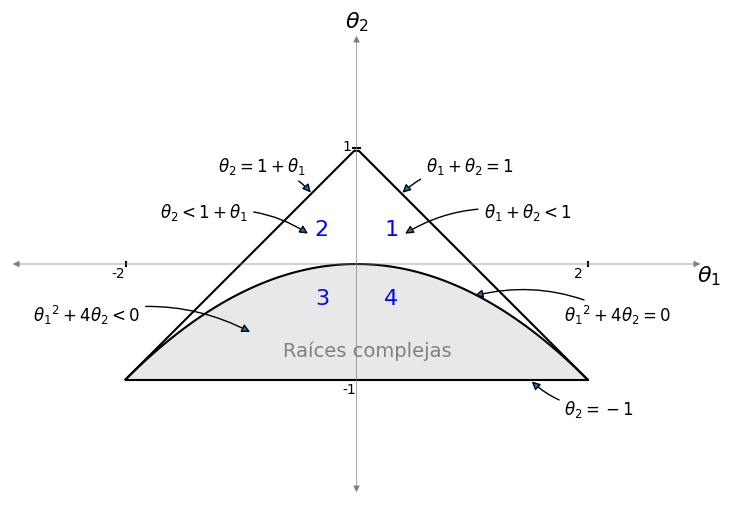

In [30]:
def MA2_param_plot():

    fig, ax = plt.subplots(figsize=(10, 6))
    ax.set_aspect('equal')

    # Set axis
    xmin, ymin = -3, -2
    xmax, ymax = -xmin, -ymin
    plt.axis([xmin, xmax, ymin, ymax])

    # Set axis labels
    ax.set(xticks=[], yticks=[])
    ax.set_xlabel(r'$\theta_2$', fontsize=16)
    ax.xaxis.set_label_position('top')
    ax.set_ylabel(r'$\theta_1$', rotation=0, fontsize=16)
    ax.yaxis.set_label_position('right')

    # Draw (t1, t2) points
    p1 = np.linspace(-2, 2, 100)
    ax.plot(p1, -abs(p1) + 1, c='black')
    ax.plot(p1, np.full_like(p1, -1), c='black')
    ax.plot(p1, -(p1**2 / 4), c='black')

    # Fill the region below the parabola and above the base of the triangle
    ax.fill_between(p1, -(p1**2 / 4), -1, where=-(p1**2 / 4) >= -1, color='lightgray', alpha=0.5)

    # Turn normal axes off
    for spine in ['left', 'bottom', 'top', 'right']:
        ax.spines[spine].set_visible(False)
        
    # Add arrows to represent axes
    axes_arrows = {'arrowstyle': '<|-|>', 'lw': 0.5, 'color': 'gray'}  # Hacerlas grises y más finas
    ax.annotate('', xy=(xmin, 0), xytext=(xmax, 0), arrowprops=axes_arrows)
    ax.annotate('', xy=(0, ymin), xytext=(0, ymax), arrowprops=axes_arrows)

    # Annotate the plot with equations
    plot_arrowsl = {'arrowstyle': '-|>', 'connectionstyle': "arc3, rad=-0.2"}
    plot_arrowsr = {'arrowstyle': '-|>', 'connectionstyle': "arc3, rad=0.2"}
    ax.annotate(r'$\theta_1 + \theta_2 < 1$', xy=(0.4, 0.25), xytext=(1.1, 0.4),
                arrowprops=plot_arrowsr, fontsize='12')
    ax.annotate(r'$\theta_1 + \theta_2 = 1$', xy=(0.38, 0.6), xytext=(0.6, 0.8),
                arrowprops=plot_arrowsr, fontsize='12')
    ax.annotate(r'$\theta_2 < 1 + \theta_1$', xy=(-0.4, 0.25), xytext=(-1.7, 0.4),
                arrowprops=plot_arrowsl, fontsize='12')
    ax.annotate(r'$\theta_2 = 1 + \theta_1$', xy=(-0.38, 0.6), xytext=(-1.2, 0.8),
                arrowprops=plot_arrowsl, fontsize='12')
    ax.annotate(r'$\theta_2 = -1$', xy=(1.5, -1), xytext=(1.8, -1.3),
                arrowprops=plot_arrowsl, fontsize='12')
    ax.annotate(r'${\theta_1}^2 + 4\theta_2 = 0$', xy=(1.0, -0.28),
                xytext=(1.8, -0.5), arrowprops=plot_arrowsr, fontsize='12')
    ax.annotate(r'${\theta_1}^2 + 4\theta_2 < 0$', xy=(-.9, -0.6),
                xytext=(-2.8, -0.5), arrowprops=plot_arrowsl, fontsize='12')

    # Label complex region
    ax.text(0.09, -0.8, 'Raíces complejas', ha='center', fontsize=14, color='gray')
    
    # Label cases
    ax.text(.3, 0.25, '1', ha='center', fontsize=16, color='blue')
    ax.text(-.3, 0.25, '2', ha='center', fontsize=16, color='blue')
    ax.text(-.3, -0.35, '3', ha='center', fontsize=16, color='blue')
    ax.text(.3, -0.35, '4', ha='center', fontsize=16, color='blue')

    # Add small marker to y-axis
    ax.axhline(y=1.005, xmin=0.495, xmax=0.505, c='black')
    ax.text(-0.12, -1.12, '-1', fontsize=10)
    ax.text(-0.12, 0.98, '1', fontsize=10)

    # Add small markers to x-axis
    ax.axvline(x=-2, ymin=0.495, ymax=0.505, c='black')
    ax.axvline(x=2, ymin=0.495, ymax=0.505, c='black')
    ax.text(-2.12, -0.12, '-2', fontsize=10)
    ax.text(1.88, -0.12, '2', fontsize=10)
    
    return fig

MA2_param_plot().savefig('./img/lecc04/MA2roots.png', dpi=300, bbox_inches='tight')